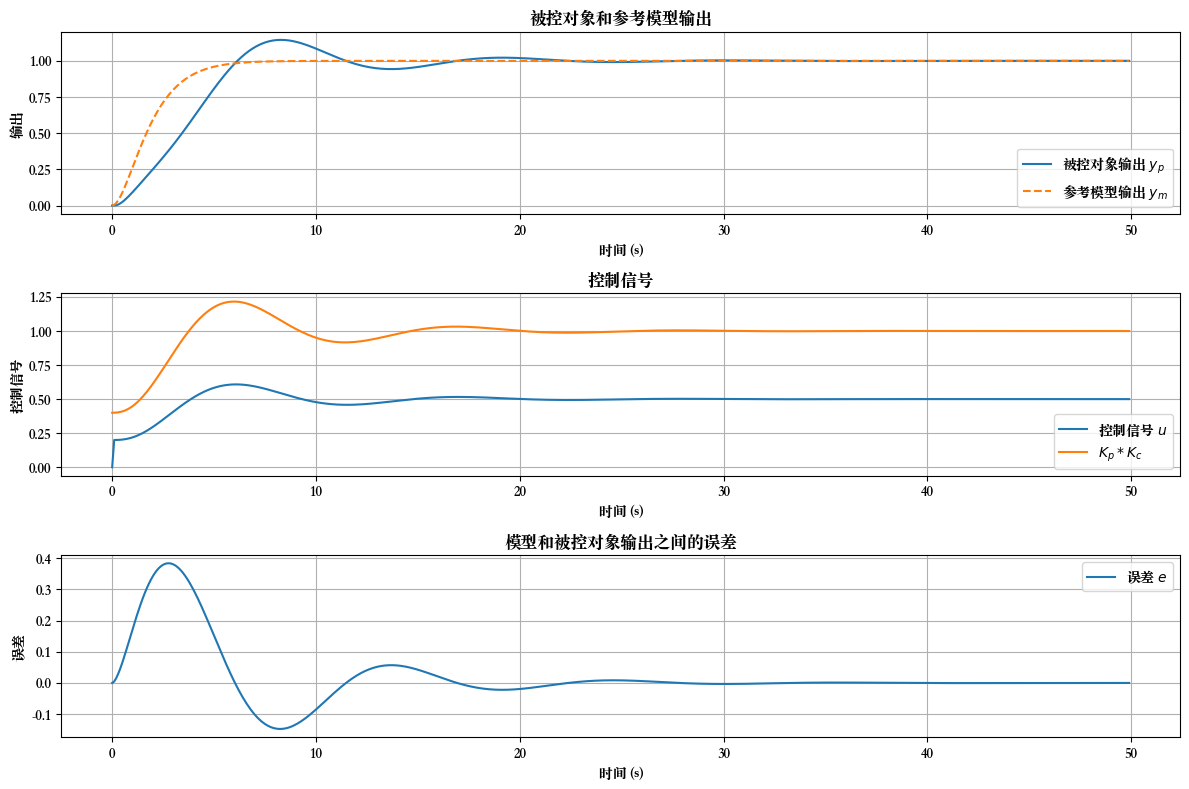

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.rcParams['font.sans-serif']=['Songti SC'] # 用来正常显示中文标签
# plt.rcParams['font.sans-serif'] = ['SimHei']    # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False      # 解决保存图像是负号'-'显示为方块的问题

# 系统参数
K_p = 2
K_m = 1
a1 = 2
a0 = 1

# MIT规则参数
K_c = 0.2  # 初始增益
B = 0.3  # 自适应增益
K_c_list = [K_c]  # 保存增益变化

# 时间设置
T = 0.1  # 采样时间
t_max = 50
t = np.arange(0, t_max, T)

# 参考信号（阶跃输入）
r = np.ones_like(t)

# 被控对象动力学
def plant_dynamics(y, t, u):
    dydt = [y[1], -a1*y[1] - a0*y[0] + K_p*u]
    return dydt

# 参考模型动力学
def model_dynamics(ym, t, r):
    dymdt = [ym[1], -a1*ym[1] - a0*ym[0] + K_m*r]
    return dymdt

# 仿真
y_p = np.zeros((len(t), 2))
y_m = np.zeros((len(t), 2))
u = np.zeros(len(t))
e = np.zeros(len(t))

for i in range(1, len(t)):
    # 被控对象输出
    y_p[i] = odeint(plant_dynamics, y_p[i-1], [t[i-1], t[i]], args=(u[i-1],))[1]
    # 参考模型输出
    y_m[i] = odeint(model_dynamics, y_m[i-1], [t[i-1], t[i]], args=(r[i],))[1]
    # 误差计算
    e[i] = y_m[i, 0] - y_p[i, 0]
    # 控制律 (u = K_c * r)
    u[i] = K_c * r[i]
    # 使用MIT规则更新控制增益
    K_c += B * e[i] * r[i] * T
    K_c_list.append(K_c)


# 计算 K_p * K_c
kp_kc = K_p * np.array(K_c_list)

# 绘制结果
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, y_p[:, 0], label='被控对象输出 $y_p$')
plt.plot(t, y_m[:, 0], label='参考模型输出 $y_m$', linestyle='--')
plt.title('被控对象和参考模型输出')
plt.xlabel('时间 (s)')
plt.ylabel('输出')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, u, label='控制信号 $u$')
plt.plot(t, kp_kc, label='$K_p * K_c$')
plt.title('控制信号')
plt.xlabel('时间 (s)')
plt.ylabel('控制信号')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, e, label='误差 $e$')
plt.title('模型和被控对象输出之间的误差')
plt.xlabel('时间 (s)')
plt.ylabel('误差')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


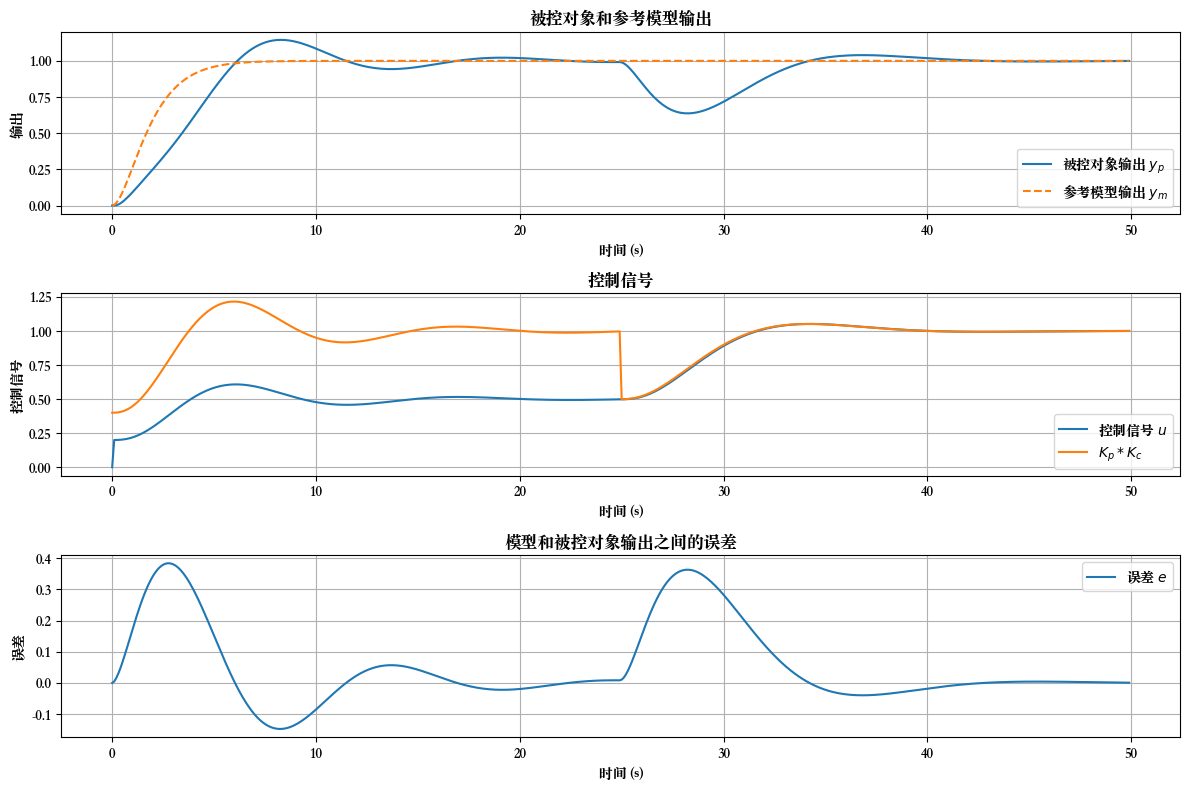

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.rcParams['font.sans-serif']=['Songti SC']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False     # 解决保存图像是负号'-'显示为方块的问题

# 系统参数
K_p = 2
K_m = 1
a1 = 2
a0 = 1

# MIT规则参数
K_c = 0.2  # 初始增益
B = 0.3  # 自适应增益
K_c_list = [K_c]  # 保存增益变化

# 时间设置
T = 0.1  # 采样时间
t_max = 50
t_change = 25  # K_p 变化时间点
t = np.arange(0, t_max, T)

# 参考信号（阶跃输入）
r = np.ones_like(t)

# 被控对象动力学
def plant_dynamics(y, t, u, K_p):
    dydt = [y[1], -a1*y[1] - a0*y[0] + K_p*u]
    return dydt

# 参考模型动力学
def model_dynamics(ym, t, r):
    dymdt = [ym[1], -a1*ym[1] - a0*ym[0] + K_m*r]
    return dymdt

# 仿真
y_p = np.zeros((len(t), 2))
y_m = np.zeros((len(t), 2))
u = np.zeros(len(t))
e = np.zeros(len(t))

for i in range(1, len(t)):
    # 被控对象输出
    if t[i] < t_change:
        current_K_p = K_p
    else:
        current_K_p = 1  # 参数收敛后，K_p 从 2 变为 1
    
    y_p[i] = odeint(plant_dynamics, y_p[i-1], [t[i-1], t[i]], args=(u[i-1], current_K_p))[1]
    # 参考模型输出
    y_m[i] = odeint(model_dynamics, y_m[i-1], [t[i-1], t[i]], args=(r[i],))[1]
    # 误差计算
    e[i] = y_m[i, 0] - y_p[i, 0]
    # 控制律 (u = K_c * r)
    u[i] = K_c * r[i]
    # 使用MIT规则更新控制增益
    K_c += B * e[i] * r[i] * T
    K_c_list.append(K_c)

# 计算 K_p * K_c
kp_kc = np.array([K_p * kc if i*T < t_change else 1 * kc for i, kc in enumerate(K_c_list)])

# 绘制结果
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, y_p[:, 0], label='被控对象输出 $y_p$')
plt.plot(t, y_m[:, 0], label='参考模型输出 $y_m$', linestyle='--')
plt.title('被控对象和参考模型输出')
plt.xlabel('时间 (s)')
plt.ylabel('输出')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, u, label='控制信号 $u$')
plt.plot(t, kp_kc, label='$K_p * K_c$')
plt.title('控制信号')
plt.xlabel('时间 (s)')
plt.ylabel('控制信号')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, e, label='误差 $e$')
plt.title('模型和被控对象输出之间的误差')
plt.xlabel('时间 (s)')
plt.ylabel('误差')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


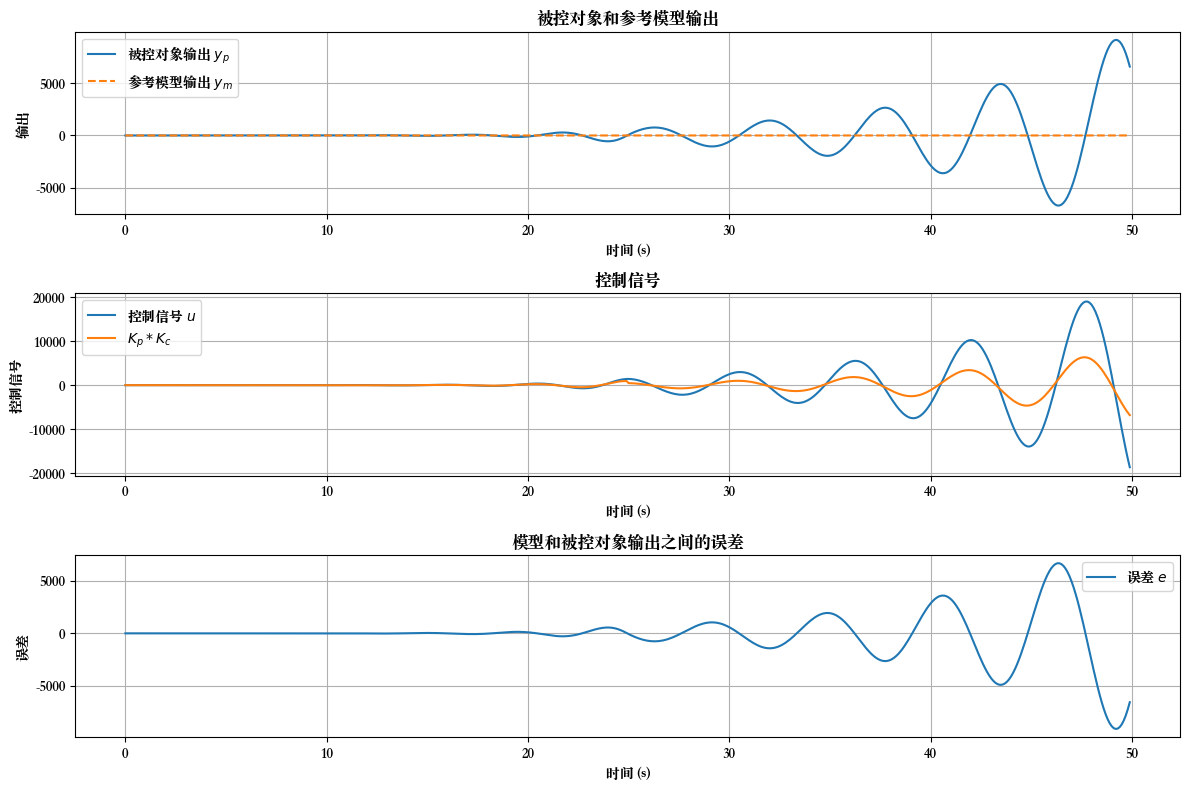

系统不稳定的A值为: 3


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.rcParams['font.sans-serif']=['Songti SC']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False     # 解决保存图像是负号'-'显示为方块的问题

# 系统参数
K_p = 2
K_m = 1
a1 = 2
a0 = 1

# MIT规则参数
K_c = 0.2  # 初始增益
B = 0.3  # 自适应增益
K_c_list = [K_c]  # 保存增益变化

# 时间设置
T = 0.1  # 采样时间
t_max = 50
t_change = 25  # K_p 变化时间点
t = np.arange(0, t_max, T)

# 参考信号（阶跃输入）
A_values = np.arange(1, 10, 1)  # 扫描的A值范围
unstable_A = None  # 用于保存系统不稳定的A值

def plant_dynamics(y, t, u, K_p):
    dydt = [y[1], -a1*y[1] - a0*y[0] + K_p*u]
    return dydt

def model_dynamics(ym, t, r):
    dymdt = [ym[1], -a1*ym[1] - a0*ym[0] + K_m*r]
    return dymdt

for A in A_values:
    r = A * np.ones_like(t)
    
    # 仿真
    y_p = np.zeros((len(t), 2))
    y_m = np.zeros((len(t), 2))
    u = np.zeros(len(t))
    e = np.zeros(len(t))
    K_c = 0.2  # 重置初始增益
    K_c_list = [K_c]
    
    for i in range(1, len(t)):
        # 被控对象输出
        if t[i] < t_change:
            current_K_p = K_p
        else:
            current_K_p = 1  # 参数收敛后，K_p 从 2 变为 1

        y_p[i] = odeint(plant_dynamics, y_p[i-1], [t[i-1], t[i]], args=(u[i-1], current_K_p))[1]
        # 参考模型输出
        y_m[i] = odeint(model_dynamics, y_m[i-1], [t[i-1], t[i]], args=(r[i],))[1]
        # 误差计算
        e[i] = y_m[i, 0] - y_p[i, 0]
        # 控制律 (u = K_c * r)
        u[i] = K_c * r[i]
        # 使用MIT规则更新控制增益
        K_c += B * e[i] * r[i] * T
        K_c_list.append(K_c)
    
    # 判断系统是否稳定
    if np.any(np.abs(e) > 10):  # 假设误差超过10认为系统不稳定
        unstable_A = A
        break

# 计算 K_p * K_c
kp_kc = np.array([K_p * kc if i*T < t_change else 1 * kc for i, kc in enumerate(K_c_list)])

# 绘制结果
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, y_p[:, 0], label='被控对象输出 $y_p$')
plt.plot(t, y_m[:, 0], label='参考模型输出 $y_m$', linestyle='--')
plt.title('被控对象和参考模型输出')
plt.xlabel('时间 (s)')
plt.ylabel('输出')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, u, label='控制信号 $u$')
plt.plot(t, kp_kc, label='$K_p * K_c$')
plt.title('控制信号')
plt.xlabel('时间 (s)')
plt.ylabel('控制信号')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, e, label='误差 $e$')
plt.title('模型和被控对象输出之间的误差')
plt.xlabel('时间 (s)')
plt.ylabel('误差')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# 输出不稳定的A值
if unstable_A is not None:
    print(f"系统不稳定的A值为: {unstable_A}")
else:
    print("在给定范围内，系统保持稳定")


In [8]:
def routh_hurwitz(coeffs):
    """
    劳斯判据检查多项式稳定性。
    :param coeffs: 多项式系数，从最高次幂到常数项。
    :return: 如果稳定则返回 True，否则返回 False。
    """
    n = len(coeffs)
    if n == 0:
        return True

    # 初始化劳斯表
    routh = np.zeros((n, (n + 1) // 2))
    routh[0, :len(coeffs[::2])] = coeffs[::2]
    routh[1, :len(coeffs[1::2])] = coeffs[1::2]

    # 构建劳斯表
    for i in range(2, n):
        for j in range((n - 1) // 2):
            if routh[i-1, 0] == 0:
                routh[i-1, 0] = 1e-4  # 如果前一行的首项为零，则用小数代替

            if routh[i-1, j] != 0:
                routh[i, j] = (routh[i-1, 0] * routh[i-2, j+1] - routh[i-2, 0] * routh[i-1, j+1]) / routh[i-1, 0]
            else:
                routh[i, j] = 0

    # 检查劳斯表的首列是否全为正数
    first_column = routh[:, 0]
    if np.any(first_column <= 0):
        return False
    return True

# 示例特征方程的系数
coeffs = [1, a1, a0]  # 例如 s^2 + a1*s + a0 = 0
stable = routh_hurwitz(coeffs)
print(f"系统是否稳定: {stable}")


系统是否稳定: True
